In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# Define the QNetwork class
class QNetwork(tf.keras.Model):
    def __init__(self, num_actions):
        super(QNetwork, self).__init__()
        self.layer1 = layers.Dense(32, activation='relu')
        self.layer2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(num_actions, activation=None)

    def call(self, state):
        x = self.layer1(state)
        x = self.layer2(x)
        q_values = self.output_layer(x)
        return q_values

In [3]:
# Define the DQNAgent class
class DQNAgent:
    def __init__(self, state_size, num_actions):
        self.model = QNetwork(num_actions)
        self.target_model = QNetwork(num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.num_actions = num_actions
        self.state_size = state_size
        self.epsilon = 0.1

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def train(self, state, action, reward, next_state, done):
        target = reward + (1 - done) * 0.99 * np.max(self.target_model.predict(next_state)[0])
        with tf.GradientTape() as tape:
            q_values = self.model(state, training=True)
            action_one_hot = tf.one_hot(action, self.num_actions)
            selected_q = tf.reduce_sum(tf.multiply(q_values, action_one_hot), axis=1)
            loss = tf.reduce_mean(tf.square(selected_q - target))
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

In [4]:
# Define a simple 2D grid world environment with visualization
class GridWorldEnvironment:
    def __init__(self, size=5):
        self.size = size
        self.state_space = np.arange(size)
        self.action_space = np.arange(4)  # 0: Up, 1: Down, 2: Left, 3: Right
        self.goal_state = (size-1, size-1)
        self.current_state = (0, 0)

    def reset(self):
        self.current_state = (0, 0)
        return self.current_state

    def step(self, action):
        if action == 0 and self.current_state[0] > 0:
            self.current_state = (self.current_state[0] - 1, self.current_state[1])  # Move Up
        elif action == 1 and self.current_state[0] < self.size - 1:
            self.current_state = (self.current_state[0] + 1, self.current_state[1])  # Move Down
        elif action == 2 and self.current_state[1] > 0:
            self.current_state = (self.current_state[0], self.current_state[1] - 1)  # Move Left
        elif action == 3 and self.current_state[1] < self.size - 1:
            self.current_state = (self.current_state[0], self.current_state[1] + 1)  # Move Right

        # Check if the goal is reached
        done = self.current_state == self.goal_state

        # Calculate reward
        reward = 1.0 if done else 0.0

        return self.current_state, reward, done, {}

    def visualize(self, path=None):
        plt.figure(figsize=(self.size, self.size))

        # Mark goal state
        plt.text(self.goal_state[1], self.goal_state[0], 'G', fontsize=12, ha='center', va='center', color='green')

        # Mark current state
        plt.text(self.current_state[1], self.current_state[0], 'A', fontsize=12, ha='center', va='center', color='red')

        # Plot grid lines
        for i in range(self.size + 1):
            plt.axhline(i, color='black', lw=2)
            plt.axvline(i, color='black', lw=2)

        # Hide axes
        plt.xticks([])
        plt.yticks([])

        # Display path if provided
        if path is not None:
            for state in path:
                plt.text(state[1], state[0], 'X', fontsize=12, ha='center', va='center', color='blue')

        plt.show()

In [37]:
# First training with 50 episodes and 25 convergence threshold
# Main training loop with visualizations, average reward, and convergence analysis
env = GridWorldEnvironment(size=5)
state_size = 2  # 2D grid world, state is represented as (row, column)
num_actions = 4  # Up, Down, Left, Right
agent = DQNAgent(state_size, num_actions)

num_episodes = 50
episode_rewards = []
average_rewards = []

convergence_threshold = 25  # Adjust as needed

for episode in range(num_episodes):
    state = env.reset()

    total_reward = 0
    path = [state]  # Record the path for visualization

    for time in range(100):  # Maximum time steps per episode
        state_reshaped = np.reshape(state, [1, state_size])

        action = agent.select_action(state_reshaped)
        next_state, reward, done, _ = env.step(action)

        next_state_reshaped = np.reshape(next_state, [1, state_size])

        agent.train(state_reshaped, action, reward, next_state_reshaped, done)

        total_reward += reward
        state = next_state

        path.append(state)  # Record the path for visualization

        if done:
            break

    episode_rewards.append(total_reward)
    agent.update_target_model()

    # Calculate and record average reward
    average_reward = np.mean(episode_rewards[-convergence_threshold:])
    average_rewards.append(average_reward)

    if episode % 50 == 0:
        print("Episode {}: Total Reward: {} , Average Reward: {}".format(episode + 1, total_reward, average_reward))

    # Check for convergence
    if episode >= convergence_threshold and np.all(np.isclose(average_rewards[-convergence_threshold:], average_reward)):
        print("Convergence reached. Average reward stabilized.")
        break

1/1 [==============================] - 0s 20ms/step
Episode 1: Total Reward: 0.0 , Average Reward: 0.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 16ms/step


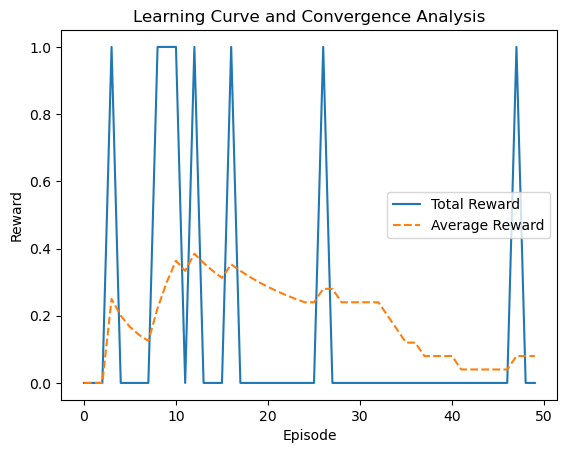

In [38]:
# Learning Curve Analysis (Performance Metrics)
plt.plot(episode_rewards, label='Total Reward')
plt.plot(average_rewards, label='Average Reward', linestyle='--')
plt.title('Learning Curve and Convergence Analysis')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

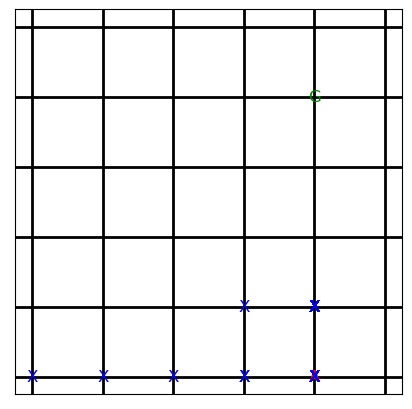

A: Agent current state
G: Goal state
X: Taken state


In [39]:
env.visualize(path)
print("A: Agent current state")
print("G: Goal state")
print("X: Taken state")

In [46]:
# Second training with 10 episodes and 5 convergence threshold
# Main training loop with visualizations, average reward, and convergence analysis
env = GridWorldEnvironment(size=5)
state_size = 2  # 2D grid world, state is represented as (row, column)
num_actions = 4  # Up, Down, Left, Right
agent = DQNAgent(state_size, num_actions)

num_episodes = 10
episode_rewards = []
average_rewards = []

convergence_threshold = 5  # Adjust as needed

for episode in range(num_episodes):
    state = env.reset()

    total_reward = 0
    path = [state]  # Record the path for visualization

    for time in range(100):  # Maximum time steps per episode
        state_reshaped = np.reshape(state, [1, state_size])

        action = agent.select_action(state_reshaped)
        next_state, reward, done, _ = env.step(action)

        next_state_reshaped = np.reshape(next_state, [1, state_size])

        agent.train(state_reshaped, action, reward, next_state_reshaped, done)

        total_reward += reward
        state = next_state

        path.append(state)  # Record the path for visualization

        if done:
            break

    episode_rewards.append(total_reward)
    agent.update_target_model()

    # Calculate and record average reward
    average_reward = np.mean(episode_rewards[-convergence_threshold:])
    average_rewards.append(average_reward)

    if episode % 50 == 0:
        print("Episode {}: Total Reward: {} , Average Reward: {}".format(episode + 1, total_reward, average_reward))

    # Check for convergence
    if episode >= convergence_threshold and np.all(np.isclose(average_rewards[-convergence_threshold:], average_reward)):
        print("Convergence reached. Average reward stabilized.")
        break

1/1 [==============================] - 0s 56ms/step
Episode 1: Total Reward: 1.0 , Average Reward: 1.0
1/1 [==============================] - 0s 33ms/step
Convergence reached. Average reward stabilized.


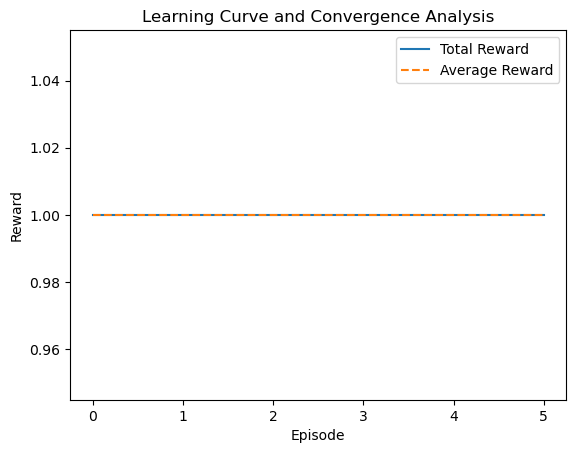

In [47]:
# Learning Curve Analysis (Performance Metrics)
plt.plot(episode_rewards, label='Total Reward')
plt.plot(average_rewards, label='Average Reward', linestyle='--')
plt.title('Learning Curve and Convergence Analysis')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

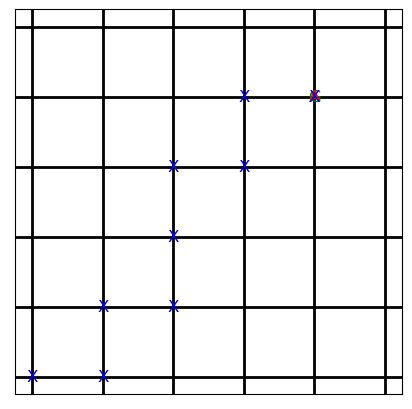

A: Agent current state
G: Goal state
X: Taken state


In [48]:
env.visualize(path)
print("A: Agent current state")
print("G: Goal state")
print("X: Taken state")